# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from modularisation.vdp_utils import *
from modularisation.model_utils import *
from modularisation.eval_utils import *
from modularisation.magnetic_field import *
from modularisation.particle import *

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
from itertools import product
from mpl_toolkits.mplot3d import Axes3D  # 3D projection
import numpy as np
import os
import time
import math

# VDP

### Functions


In [3]:
# parameters
dt = 0.1  # time step
t_end = 30  # total time
t0 = 0  # initial time
N = int(t_end / dt)  # number of time steps
M = 10
device = "cuda" if torch.cuda.is_available() else "cpu"
x0 = torch.tensor([2.0, 2.0], dtype=torch.float32).to(device)

### Single step predictions 

#### VDP Data load in

In [4]:
X_loaded, K_loaded = torch.load("Data/VDP/VDP_Training.pt")

X, K = X_loaded.to(device), K_loaded.to(device)

#### VDP Example training

In [5]:
# 1) Select device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# 2) RK4 tableau
rk4 = {
    "A": [
        [0.0, 0.0, 0.0, 0.0],
        [0.5, 0.0, 0.0, 0.0],
        [0.0, 0.5, 0.0, 0.0],
        [0.0, 0.0, 1.0, 0.0],
    ],
    "b": [1/6, 1/3, 1/3, 1/6],
    "c": [0.0, 0.5, 0.5, 1.0],
}

# 3) Create model & optimizer
model = NeuralRK(hidden_dim=16, num_layers=2, butcher=rk4, dt=dt).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
print(model.num_layers, model.hidden_dim, model.dt)

# 4) Make sure your training data X,K are on the same device
X = X.to(device)
K = K.to(device)

# 5) Convergence parameters
min_epochs = 100
patience   = 20
delta_tol  = 1e-6
max_epochs = 100000     # safety cap
batch_size = 64

best_loss = float("inf")
wait      = 0
epoch     = 0

# 6) Training loop
if not model.does_model_exist("VDP", "RK4"):
    print("Starting training...")
    print(f'model name : NeuralRK_VDP_hd{model.hidden_dim}_layers{model.num_layers}_dt{model.dt}_RK4.pt')
    while True:
        # Sample a random batch (on-device)
        idx = torch.randperm(X.size(0), device=device)[:batch_size]
        x_batch = X[idx]
        k_batch = K[idx]

        optimizer.zero_grad()
        loss = model.loss_fn(x_batch, k_batch)
        loss.backward()
        optimizer.step()

        loss_val = loss.item()

        # Initialize best_loss on the first epoch
        if epoch == 0:
            best_loss = loss_val

        # Logging
        if epoch % 100 == 0:
            print(f"Epoch {epoch:5d} | Loss = {loss_val:.6e} | Best = {best_loss:.6e} | Wait = {wait}")

        # Check convergence once we've done min_epochs
        if epoch >= min_epochs:
            if abs(loss_val - best_loss) < delta_tol:
                wait += 1
                if wait >= patience:
                    print(f"\nConverged at epoch {epoch} | loss = {loss_val:.6e}")
                    break
            else:
                best_loss = loss_val
                wait = 0

        epoch += 1
        if epoch >= max_epochs:
            print("\nStopping early: reached max epochs.")
            break

    # Save the model
    if not os.path.exists("RK_PINNs/Results/VDP/Models"):
        os.makedirs("RK_PINNs/Results/VDP/Models")

    model.save_model("VDP", "RK4")

elif model.does_model_exist("VDP", "RK4"):
    print(f'Model already exists: NeuralRK_VDP_hd{model.hidden_dim}_layers{model.num_layers}_dt{model.dt}_RK4.pt')
    model.load_state_dict(torch.load(model.name_model("VDP", "RK4"))["model_state_dict"])

    print("Model loaded successfully.")


Using device: cuda
2 16 0.1
Checked path: Results\VDP\Models\NeuralRK_VDP_hd16_layers2_dt0.1_RK4.pt
Checked path: Results\VDP\Models\NeuralRK_VDP_hd16_layers2_dt0.1_RK4.pt
Model already exists: NeuralRK_VDP_hd16_layers2_dt0.1_RK4.pt
Model loaded successfully.


Saved figure to c:\Users\GeorgeWilliam\Documents\GitHub\TrackExtrapolation\RK_PINNs\full_mode_analysis_20250903_160245.png


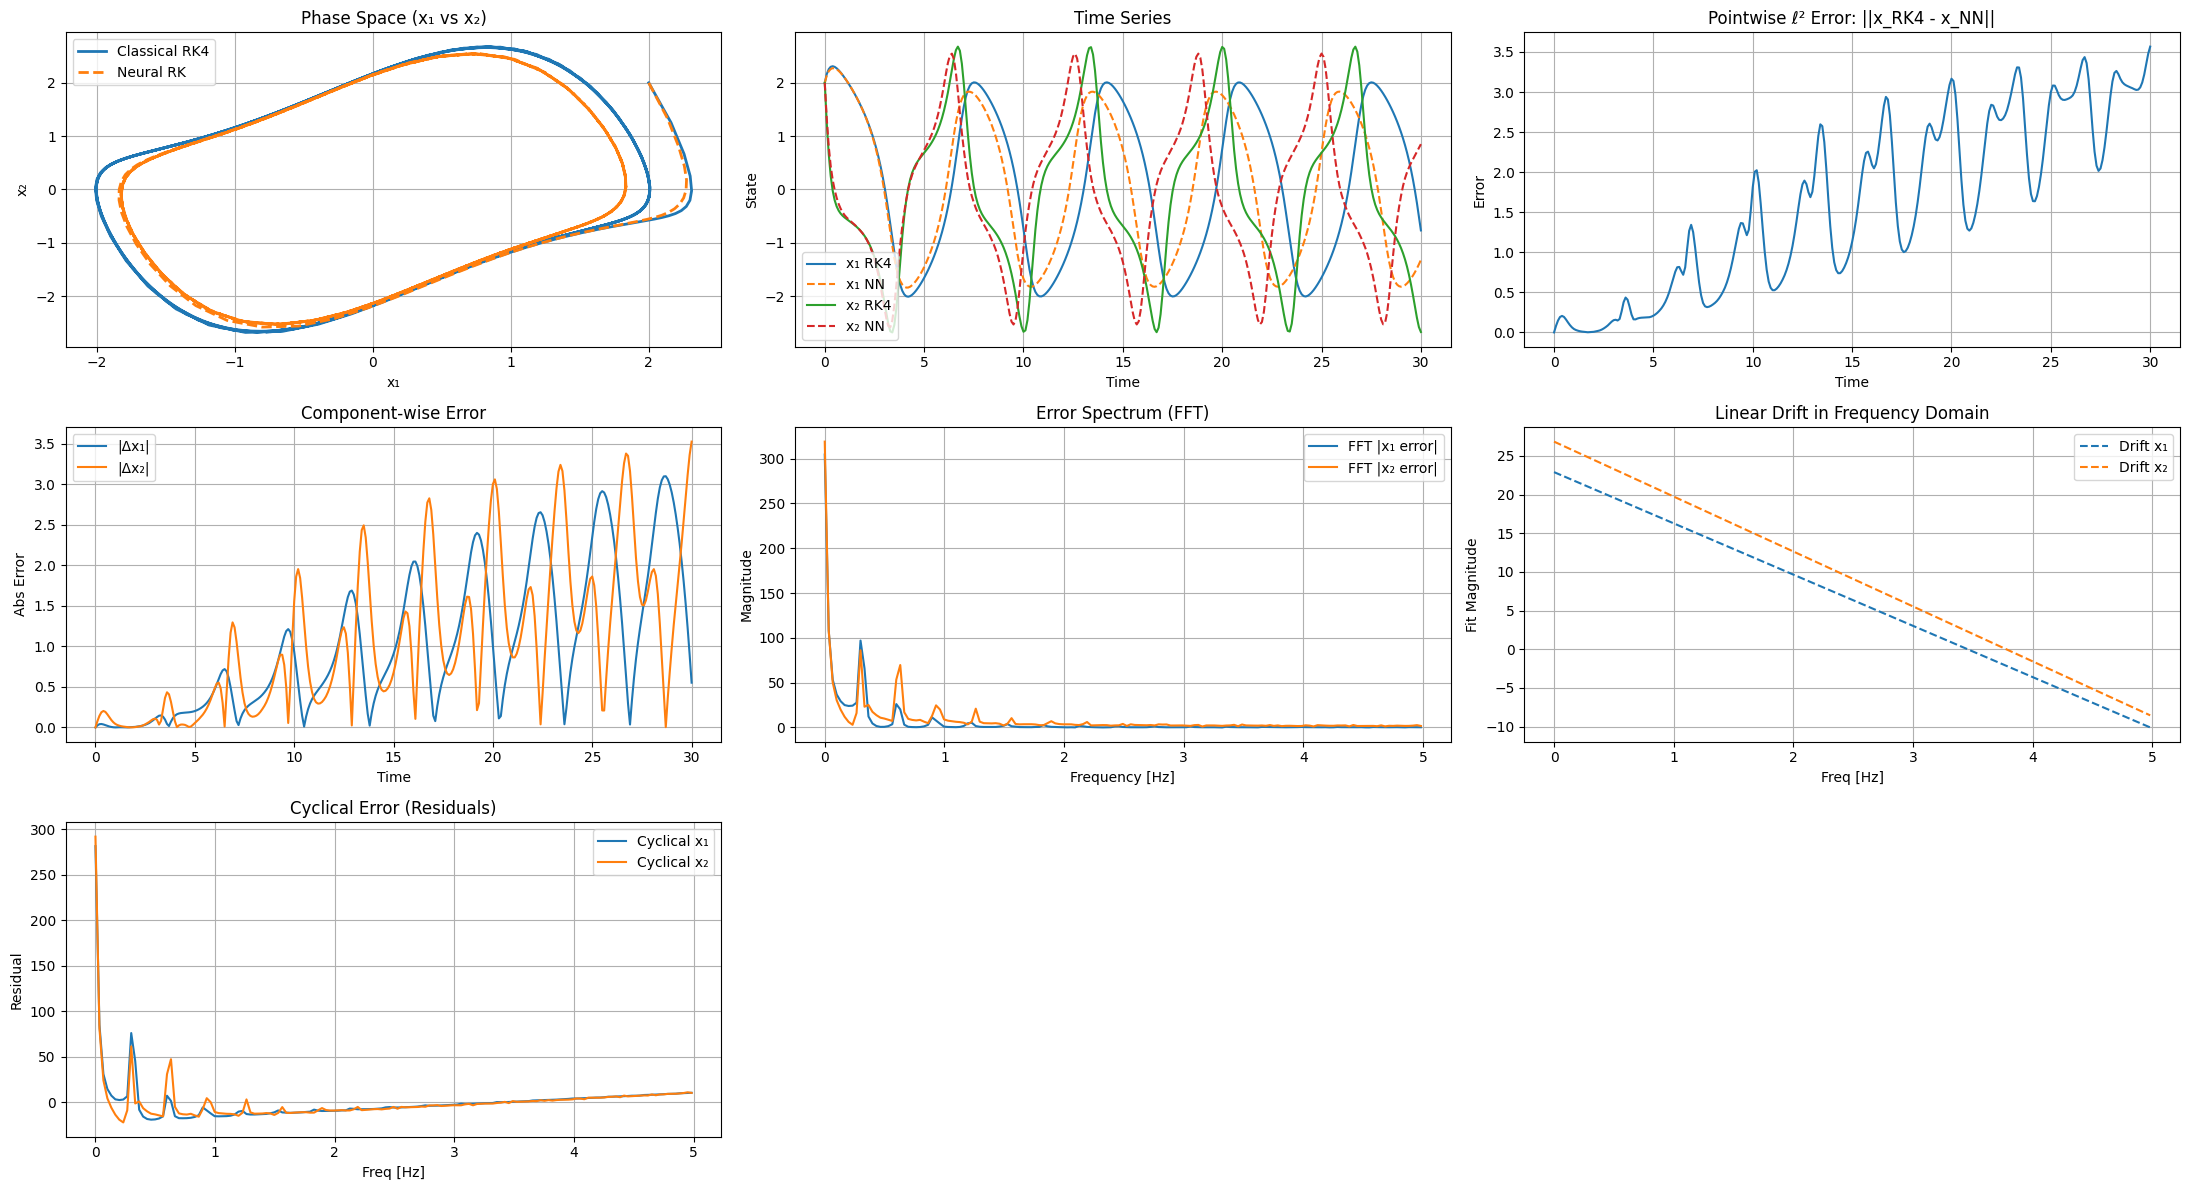

In [6]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import rfft, rfftfreq

# === Parameters ===
steps = N
x0 = torch.tensor([2, 2], dtype=torch.float32).to(device)

# === Rollouts ===
traj_nn = rollout_neural_model(model, x0, steps, dt)
traj_rk = rollout_rk4(x0, steps, dt, 10, rk4, vdp)

full_mode_analysis(traj_rk, traj_nn, steps, dt)


In [7]:
# Generate multiple initial conditions
n_ic = 20
x0_set = torch.stack([
    torch.tensor([torch.rand(1).item() * 4 - 2, torch.rand(1).item() * 4 - 2])
    for _ in range(n_ic)
])

# Compute errors
errors = evaluate_final_error(
    model=model,
    m = M,
    butcher=rk4,
    f=vdp,
    x0_set=x0_set,
    t_end=dt,
    dt=0.1
)

# Report
print("Mean final-time error:", errors.mean().item())
print("Max final-time error: ", errors.max().item())


Mean final-time error: 0.03044775500893593
Max final-time error:  0.15564601123332977


#### Comparing Architectures

In [8]:
# === Configurations ===
hidden_dims = [i for i in [2,4,8,16]]  # hidden dimensions
num_layers_list = [1,2,3,4]
repeats = 1  # optional repeat per config


dt = 0.1
steps = N
device = "cuda" if torch.cuda.is_available() else "cpu"

results = []

# Convergence criterion parameters:
max_epochs = 100000         # Maximum training epochs allowed
tol = 1e-6                 # Minimum loss improvement required
patience = 20              # Number of epochs without improvement to wait

x0_eval = sample_initial_conditions(20).to(device)

# === Loop over Configurations ===
for hidden_dim, num_layers in product(hidden_dims, num_layers_list):
    print(f"Training model with hidden_dim={hidden_dim}, num_layers={num_layers}")
    

    # Initialize model and optimizer
    model = NeuralRK(hidden_dim=hidden_dim, num_layers=num_layers, butcher=rk4, dt=dt).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    

  # Training loop with convergence
    min_epochs = 100
    patience = 20
    delta_tol = 1e-6

    best_loss = float('inf')
    wait = 0
    epoch = 0
    max_epochs = 100000  # safety cap

    if not model.does_model_exist("VDP", "RK4"):

        while True:
            idx = torch.randperm(X.size(0))
            x_batch = X[idx[:64]]
            k_batch = K[idx[:64]]

            optimizer.zero_grad()
            loss = model.loss_fn(x_batch, k_batch)
            loss.backward()
            optimizer.step()

            loss_val = loss.item()

            if epoch % 100 == 0:
                print(f"Epoch {epoch:4d}: Loss = {loss_val:.6f}")

            if epoch >= min_epochs:
                if abs(loss_val - best_loss) < delta_tol:
                    wait += 1
                    if wait >= patience:
                        print(f"Converged after {epoch} epochs with loss {loss_val:.6f}")
                        break
                else:
                    wait = 0
                    best_loss = loss_val

            epoch += 1
            if epoch >= max_epochs:
                print("Stopped early: max epochs reached.")
                break
        
        print(f"Converged in {epoch} epochs with best loss {best_loss:.4e}")
        # Save the model
        model.save_model("VDP", "RK4")

Training model with hidden_dim=2, num_layers=1
Checked path: Results\VDP\Models\NeuralRK_VDP_hd2_layers1_dt0.1_RK4.pt
Training model with hidden_dim=2, num_layers=2
Checked path: Results\VDP\Models\NeuralRK_VDP_hd2_layers2_dt0.1_RK4.pt
Training model with hidden_dim=2, num_layers=3
Checked path: Results\VDP\Models\NeuralRK_VDP_hd2_layers3_dt0.1_RK4.pt
Training model with hidden_dim=2, num_layers=4
Checked path: Results\VDP\Models\NeuralRK_VDP_hd2_layers4_dt0.1_RK4.pt
Training model with hidden_dim=4, num_layers=1
Checked path: Results\VDP\Models\NeuralRK_VDP_hd4_layers1_dt0.1_RK4.pt
Training model with hidden_dim=4, num_layers=2
Checked path: Results\VDP\Models\NeuralRK_VDP_hd4_layers2_dt0.1_RK4.pt
Training model with hidden_dim=4, num_layers=3
Checked path: Results\VDP\Models\NeuralRK_VDP_hd4_layers3_dt0.1_RK4.pt
Training model with hidden_dim=4, num_layers=4
Checked path: Results\VDP\Models\NeuralRK_VDP_hd4_layers4_dt0.1_RK4.pt
Training model with hidden_dim=8, num_layers=1
Checked p

In [9]:
evaluate_and_time_saved_models(steps=1,m=M,butcher=rk4, f=vdp, x0_eval=x0_eval, x0=x0,t_end=dt, dt=0.1, device=device)

Failed NeuralRK_VDP_hd16_layers2_dt0.1_RK4_PHYS.pt: Error(s) in loading state_dict for NeuralRK:
	Missing key(s) in state_dict: "net.6.weight", "net.6.bias". 
	size mismatch for net.0.weight: copying a param with shape torch.Size([16, 2]) from checkpoint, the shape in current model is torch.Size([64, 2]).
	size mismatch for net.0.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for net.2.weight: copying a param with shape torch.Size([16, 16]) from checkpoint, the shape in current model is torch.Size([64, 64]).
	size mismatch for net.2.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for net.4.weight: copying a param with shape torch.Size([8, 16]) from checkpoint, the shape in current model is torch.Size([64, 64]).
	size mismatch for net.4.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current mo

,model,mean_error,max_error,rollout_time,hidden_dim,num_layers,dt
0,NeuralRK_VDP_hd16_layers1_dt0.1_RK4.pt,0.046229,0.251167,0.001014,16,1,0.1
1,NeuralRK_VDP_hd16_layers2_dt0.1_RK4.pt,0.030013,0.119023,0.001006,16,2,0.1
2,NeuralRK_VDP_hd16_layers3_dt0.1_RK4.pt,0.045368,0.249651,0.001001,16,3,0.1
3,NeuralRK_VDP_hd16_layers4_dt0.1_RK4.pt,0.030799,0.179304,0.001130,16,4,0.1
4,NeuralRK_VDP_hd2_layers1_dt0.1_RK4.pt,0.284193,1.661010,0.000000,2,1,0.1
5,NeuralRK_VDP_hd2_layers2_dt0.1_RK4.pt,2.871701,42.041096,0.000999,2,2,0.1
6,NeuralRK_VDP_hd2_layers3_dt0.1_RK4.pt,0.682456,5.585707,0.000993,2,3,0.1
7,NeuralRK_VDP_hd2_layers4_dt0.1_RK4.pt,0.597170,5.171816,0.000997,2,4,0.1
8,NeuralRK_VDP_hd4_layers1_dt0.1_RK4.pt,0.168998,0.826380,0.000998,4,1,0.1
9,NeuralRK_VDP_hd4_layers2_dt0.1_RK4.pt,0.116836,0.611416,0.000999,4,2,0.1


c:\Users\GeorgeWilliam\Documents\GitHub\TrackExtrapolation\RK_PINNs\modularisation\eval_utils.py:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hidden_dim'] = df['model'].str.extract(r'hd(\d+)').astype(float)
c:\Users\GeorgeWilliam\Documents\GitHub\TrackExtrapolation\RK_PINNs\modularisation\eval_utils.py:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['num_layers'] = df['model'].str.extract(r'layers(\d+)').astype(float)


Saved figure to c:\Users\GeorgeWilliam\Documents\GitHub\TrackExtrapolation\RK_PINNs\mean_max_errors_20250903_160020.png


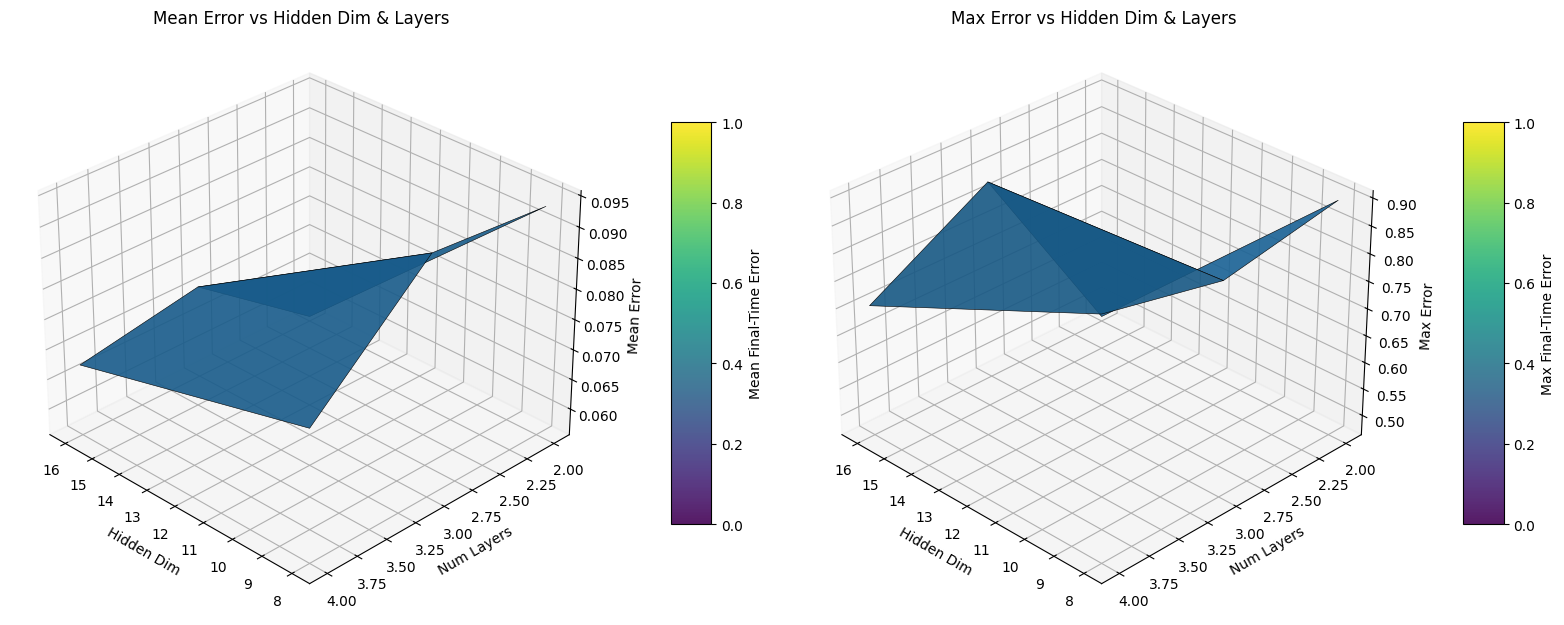

In [13]:
df = pd.read_csv("rk_nn_saved_models_evaluation_with_timing.csv")
plot_mean_and_max_errors_separately(df[df['mean_error'] < 0.1])  # Filter for better visibility

Saved figure to c:\Users\GeorgeWilliam\Documents\GitHub\TrackExtrapolation\RK_PINNs\training_data_20250903_160021.png


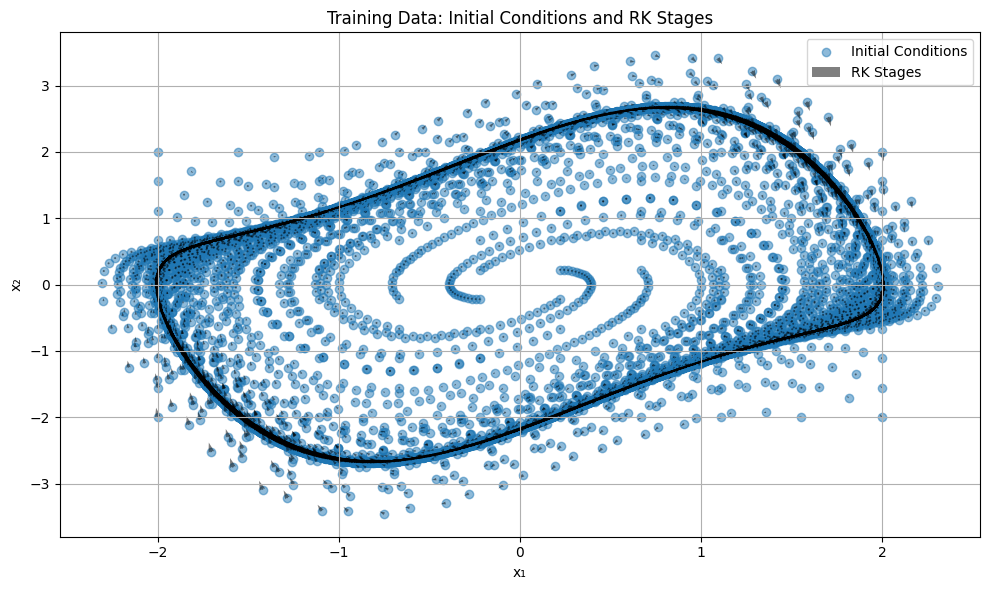

In [14]:
plot_training_data(X, K)

In [16]:
# === Run evaluation ===
df_nn = evaluate_and_time_saved_models(steps=1,m=M,butcher=rk4, f=vdp, x0_eval=x0_eval, x0=x0,t_end=0.1, dt=0.1, device=device)
df_rk = rk_timmer(steps=1,m = 100, Ms=[i for i in range(1, 11)],model=model,butcher=rk4,x0_eval=x0_eval,x0=x0,t_end=dt, dt=dt,f=vdp)

# === Plot results ===
plot_accuracy_and_timing_comparison(df_nn[df_nn['mean_error'] < 0.1], df_rk)


NameError: name 'x0' is not defined

### With gradients in the training

In [ ]:
# python
# (run after you already executed the imports and loaded X,K, defined rk4, vdp, device, M, dt)
import time
import torch
import torch.nn.functional as F

# vectorized vdp wrapper (vdp in modularisation.vdp_utils expects a single state)
def vdp_batched(x: torch.Tensor) -> torch.Tensor:
    # x: (N, d) or (d,)
    if x.dim() == 1:
        return vdp(x)
    return torch.stack([vdp(xi) for xi in x], dim=0).to(x.device)

# ...existing code...

def compute_rk_physics_loss(
    model,
    x: torch.Tensor,
    k_true: Optional[torch.Tensor],
    dt: float,
    butcher: Dict[str, List[Any]],
    f: Callable[[torch.Tensor], torch.Tensor],
    w_stage: float = 1.0,
    w_step: float = 1.0,
    w_consistency: float = 1.0,
    jacobian_weight: float = 0.0,
    jacobian_samples: int = 1,
    debug: bool = False,
):
    """
    Composite RK-PINN loss with shape checks and flattened-output handling.
    """
    device = next(model.parameters()).device
    x = x.to(device).float()
    if k_true is not None:
        k_true = k_true.to(device).float()

    # validate butcher early and infer expected stage count
    if "A" not in butcher or "b" not in butcher:
        raise ValueError("butcher must contain 'A' and 'b' entries")
    s_butcher = int(len(butcher["b"]))

    # attempt to infer state dimension d (fallbacks)
    if k_true is not None:
        if k_true.dim() == 3:
            d_est = int(k_true.shape[2])
        elif k_true.dim() == 4:
            d_est = int(k_true.shape[3])
        else:
            d_est = int(x.shape[-1])
    else:
        d_est = int(x.shape[-1])

    # model prediction: handle both (B, s, d) and flattened (B, s*d)
    k_pred = model(x)
    if isinstance(k_pred, tuple):
        k_pred = k_pred[0]
    if k_pred.dim() == 2:
        # possible flattened output (B, s*d)
        if k_pred.shape[1] == s_butcher * d_est:
            k_pred = k_pred.view(k_pred.shape[0], s_butcher, d_est)
            if debug:
                print(f"[debug] reshaped flattened model output to (B,s,d) = {k_pred.shape}")
        else:
            raise RuntimeError(
                f"Model returned 2D output with shape {tuple(k_pred.shape)} but cannot "
                f"interpret as (B, s*d) with s={s_butcher}, d={d_est}. "
                "If your model is a trajectory model, use the trajectory training utilities; "
                "or make the model return (B, s, d)."
            )
    elif k_pred.dim() != 3:
        raise RuntimeError(f"Unexpected model output ndim={k_pred.dim()}, expected 3 (B,s,d) or flattened 2 (B,s*d).")

    B, s, d = k_pred.shape

    # Build butcher tensors and validate shapes
    A_mat = torch.tensor(butcher["A"], dtype=k_pred.dtype, device=device)
    b_vec = torch.tensor(butcher["b"], dtype=k_pred.dtype, device=device).view(-1)

    if A_mat.dim() != 2 or A_mat.shape[0] != A_mat.shape[1]:
        raise ValueError(f"butcher['A'] must be square, got shape {tuple(A_mat.shape)}")

    if A_mat.shape[0] != s:
        raise ValueError(
            f"Stage count mismatch: model predicts s={s} stages but butcher['A'] has shape {tuple(A_mat.shape)}. "
            "Ensure the model was constructed with the same RK tableau (same number of stages)."
        )

    if b_vec.numel() != s:
        raise ValueError(f"butcher['b'] length {b_vec.numel()} does not match stage count s={s}")

    if debug:
        print(f"[debug] x {tuple(x.shape)} k_pred {tuple(k_pred.shape)} A {tuple(A_mat.shape)} b {tuple(b_vec.shape)}")

    # stage loss
    loss_stage = F.mse_loss(k_pred, k_true) if k_true is not None else torch.tensor(0.0, device=device)

    # step loss
    b = b_vec.view(1, -1, 1)  # (1, s, 1)
    x_next_pred = x + dt * torch.sum(b * k_pred, dim=1)  # (B, d)
    if k_true is not None:
        x_next_true = x + dt * torch.sum(b * k_true, dim=1)
        loss_step = F.mse_loss(x_next_pred, x_next_true)
    else:
        loss_step = torch.tensor(0.0, device=device)

    # consistency: compute stage inputs x_stage = x + dt * A @ k_pred
    # A_mat (s,i) with k_pred (b, j, d) -> result (b, i, d)+    
    weighted = torch.einsum("ij,bjd->bid", A_mat, k_pred)
    x_stage = x.unsqueeze(1) + dt * weighted           # (B, s, d)
    x_stage = x.unsqueeze(1) + dt * weighted           # (B, s, d)
    x_stage_flat = x_stage.reshape(B * s, d)

    # f must accept batched inputs -> returns (B*s, d)
    f_stage_flat = f(x_stage_flat).to(device).float()
    f_stage = f_stage_flat.view(B, s, d)

    loss_consistency = F.mse_loss(k_pred, f_stage)

    loss = w_stage * loss_stage + w_step * loss_step + w_consistency * loss_consistency
    stats = {"stage": float(loss_stage.item()), "step": float(loss_step.item()), "consistency": float(loss_consistency.item())}

    # Hutchinson Jacobian regulariser
    if jacobian_weight > 0.0:
        x_stage_flat = x_stage_flat.detach().requires_grad_(True)
        f_flat = f(x_stage_flat)
        jac_loss_acc = 0.0
        for _ in range(max(1, int(jacobian_samples))):
            w_dir = torch.randn_like(f_flat, device=device)
            scalar_f = (f_flat * w_dir).sum()
            v_f = torch.autograd.grad(scalar_f, x_stage_flat, create_graph=True)[0]

            model_eval = model(x_stage_flat)           # (B*s, s, d) or flattened
            if isinstance(model_eval, tuple):
                model_eval = model_eval[0]
            if model_eval.dim() == 2 and model_eval.shape[1] == s * d:
                model_eval = model_eval.view(model_eval.shape[0], s, d)
            model_inst = model_eval[:, 0, :]           # choose stage-0 as instantaneous derivative (B*s, d)
            scalar_m = (model_inst * w_dir).sum()
            v_m = torch.autograd.grad(scalar_m, x_stage_flat, create_graph=True)[0]

            jac_loss_acc = jac_loss_acc + F.mse_loss(v_m, v_f)

        loss_jac = jac_loss_acc / float(max(1, int(jacobian_samples)))
        loss = loss + jacobian_weight * loss_jac
        stats["jacobian"] = float(loss_jac.item())
    else:
        stats["jacobian"] = 0.0

    return loss, stats


def train_naive(model, X, K, optimizer=None, batch_size=64, min_epochs=100, patience=20, delta_tol=1e-6, max_epochs=100000, verbose=True):
    if optimizer is None:
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    model.to(device)
    X = X.to(device); K = K.to(device)
    best_loss = float("inf"); wait = 0; epoch = 0
    history = []
    model.train()
    while True:
        idx = torch.randperm(X.size(0), device=device)[:batch_size]
        x_batch = X[idx]; k_batch = K[idx]
        optimizer.zero_grad()
        loss = model.loss_fn(x_batch, k_batch)
        loss.backward()
        optimizer.step()
        loss_val = float(loss.item()); history.append(loss_val)
        if verbose and (epoch % 100 == 0):
            print(f"[naive] Epoch {epoch:6d} | Loss = {loss_val:.6e} | Best = {best_loss:.6e} | Wait = {wait}")
        if epoch == 0:
            best_loss = loss_val
        if epoch >= min_epochs:
            if abs(loss_val - best_loss) < delta_tol:
                wait += 1
                if wait >= patience:
                    break
            else:
                best_loss = loss_val; wait = 0
        epoch += 1
        if epoch >= max_epochs:
            break
    return {"history": history, "epochs": epoch, "final_loss": history[-1]}

def train_physics(model, X, K, f, dt, butcher, optimizer=None, batch_size=64, min_epochs=100, patience=20, delta_tol=1e-6, max_epochs=100000, w_stage=1.0, w_step=0.5, w_consistency=1.0, jacobian_weight=0.0, jacobian_samples=1, verbose=True):
    if optimizer is None:
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    model.to(device)
    X = X.to(device); K = K.to(device) if K is not None else None
    best_loss = float("inf"); wait = 0; epoch = 0
    history = []
    model.train()
    while True:
        idx = torch.randperm(X.size(0), device=device)[:batch_size]
        x_batch = X[idx]; k_batch = K[idx] if K is not None else None
        optimizer.zero_grad()
        loss, stats = compute_rk_physics_loss(model, x_batch, k_batch, dt, butcher, f, w_stage=w_stage, w_step=w_step, w_consistency=w_consistency, jacobian_weight=jacobian_weight, jacobian_samples=jacobian_samples)
        loss.backward()
        optimizer.step()
        loss_val = float(loss.item()); history.append(loss_val)
        if verbose and (epoch % 100 == 0):
            print(f"[phys] Epoch {epoch:6d} | Loss = {loss_val:.6e} | stage={stats['stage']:.3e} step={stats['step']:.3e} cons={stats['consistency']:.3e} jac={stats['jacobian']:.3e} | Wait = {wait}")
        if epoch == 0:
            best_loss = loss_val
        if epoch >= min_epochs:
            if abs(loss_val - best_loss) < delta_tol:
                wait += 1
                if wait >= patience:
                    break
            else:
                best_loss = loss_val; wait = 0
        epoch += 1
        if epoch >= max_epochs:
            break
    return {"history": history, "epochs": epoch, "final_loss": history[-1]}

In [ ]:
# Set hyperparams for quick demonstration; increase min_epochs for real training
torch.manual_seed(0)
hidden_dim = 16
num_layers = 2
lr = 1e-3
batch_size = 64
min_epochs = 300            # increase for serious fits
patience = 30
dt_train = dt               # use dt defined earlier
butcher = rk4

# build two models with identical init
torch.manual_seed(0)
model_naive = NeuralRK(hidden_dim=hidden_dim, num_layers=num_layers, butcher=butcher, dt=dt_train).to(device)
torch.manual_seed(0)
model_phys = NeuralRK(hidden_dim=hidden_dim, num_layers=num_layers, butcher=butcher, dt=dt_train).to(device)

opt_naive = torch.optim.Adam(model_naive.parameters(), lr=lr)
opt_phys = torch.optim.Adam(model_phys.parameters(), lr=lr)

# small quick training runs (naive stage-only)
t0 = time.time()
res_naive = train_naive(model_naive, X, K, optimizer=opt_naive, batch_size=batch_size, min_epochs=min_epochs, patience=patience, delta_tol=1e-6, verbose=True)
t_naive = time.time() - t0
# print(f"Naive training done in {t_naive:.1f}s, epochs={res_naive['epochs']}, final_loss={res_naive['final_loss']:.4e}")

# physics-aware training (consistency + stage + step), no Jacobian for now
t0 = time.time()
res_phys = train_physics(model_phys, X, K, f=vdp_batched, dt=dt_train, butcher=butcher, optimizer=opt_phys, batch_size=batch_size, min_epochs=min_epochs, patience=patience, delta_tol=1e-6, w_stage=1.0, w_step=0.5, w_consistency=1.0, jacobian_weight=0.1, verbose=True)
t_phys = time.time() - t0
print(f"Physics training done in {t_phys:.1f}s, epochs={res_phys['epochs']}, final_loss={res_phys['final_loss']:.4e}")

# Evaluate final-time errors on sample ICs (uses evaluate_final_error from eval_utils)
x0_eval = sample_initial_conditions(20).to(device)
errs_naive = evaluate_final_error(model_naive, m=M, butcher=butcher, f=vdp, x0_set=x0_eval, t_end=dt_train, dt=dt_train)
errs_phys  = evaluate_final_error(model_phys,  m=M, butcher=butcher, f=vdp, x0_set=x0_eval, t_end=dt_train, dt=dt_train)

print("Naive mean/max final-time error:", errs_naive.mean().item(), errs_naive.max().item())
print("Physics mean/max final-time error:", errs_phys.mean().item(), errs_phys.max().item())

# plot one sample rollout for visual comparison
import matplotlib.pyplot as plt
x0 = torch.tensor([2.0, 2.0], dtype=torch.float32).to(device)
steps = N
# traj_naive = rollout_neural_model(model_naive, x0, steps, dt_train)
traj_phys  = rollout_neural_model(model_phys,  x0, steps, dt_train)
traj_rk    = rollout_rk4(x0.cpu(), steps, dt_train, 500, butcher, vdp)  # high-accuracy reference on CPU

plt.figure(figsize=(8,6))
plt.plot(traj_rk[:,0], traj_rk[:,1], label="RK4 reference", lw=2)
# plt.plot(traj_naive[:,0].cpu(), traj_naive[:,1].cpu(), '--', label="Naive NN")
plt.plot(traj_phys[:,0].cpu(), traj_phys[:,1].cpu(), ':', label="Physics-aware NN")
plt.legend(); plt.title("Phase-space rollout (sample IC)"); plt.grid(True); plt.show()

[phys] Epoch      0 | Loss = 5.983558e+00 | stage=2.973e+00 step=2.936e-02 cons=2.996e+00 jac=0.000e+00 | Wait = 0
[phys] Epoch    100 | Loss = 4.554316e+00 | stage=2.205e+00 step=2.189e-02 cons=2.338e+00 jac=0.000e+00 | Wait = 0
[phys] Epoch    200 | Loss = 1.924698e+00 | stage=9.232e-01 step=8.978e-03 cons=9.970e-01 jac=0.000e+00 | Wait = 0
[phys] Epoch    300 | Loss = 1.313869e+00 | stage=6.235e-01 step=6.136e-03 cons=6.873e-01 jac=0.000e+00 | Wait = 0
[phys] Epoch    400 | Loss = 8.696505e-01 | stage=4.263e-01 step=4.171e-03 cons=4.412e-01 jac=0.000e+00 | Wait = 0
[phys] Epoch    500 | Loss = 4.430093e-01 | stage=2.083e-01 step=2.038e-03 cons=2.337e-01 jac=0.000e+00 | Wait = 0
[phys] Epoch    600 | Loss = 1.815740e-01 | stage=7.605e-02 step=7.033e-04 cons=1.052e-01 jac=0.000e+00 | Wait = 0
[phys] Epoch    700 | Loss = 1.377550e-01 | stage=6.857e-02 step=6.286e-04 cons=6.887e-02 jac=0.000e+00 | Wait = 0
[phys] Epoch    800 | Loss = 7.114868e-02 | stage=2.484e-02 step=1.899e-04 cons=

KeyboardInterrupt: 

Physics mean/max final-time error: 0.12337398529052734 1.684086799621582


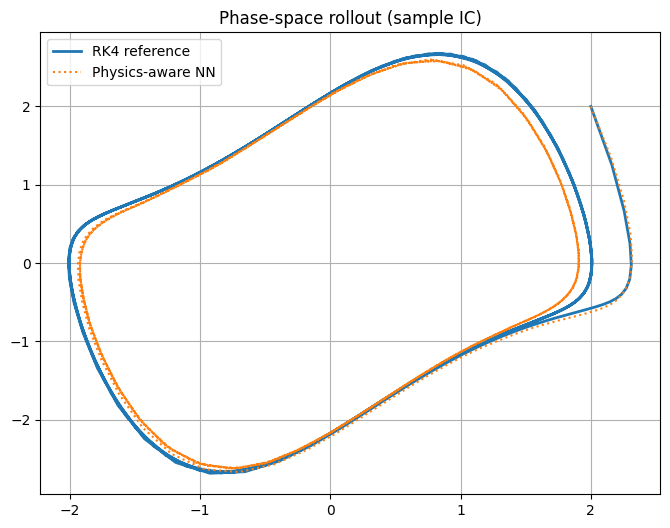

In [ ]:
t_phys = time.time() - t0
# print(f"Physics training done in {t_phys:.1f}s, epochs={res_phys['epochs']}, final_loss={res_phys['final_loss']:.4e}")

# Evaluate final-time errors on sample ICs (uses evaluate_final_error from eval_utils)
x0_eval = sample_initial_conditions(20).to(device)
# errs_naive = evaluate_final_error(model_naive, m=M, butcher=butcher, f=vdp, x0_set=x0_eval, t_end=dt_train, dt=dt_train)
errs_phys  = evaluate_final_error(model_phys,  m=M, butcher=butcher, f=vdp, x0_set=x0_eval, t_end=dt_train, dt=dt_train)

# print("Naive mean/max final-time error:", errs_naive.mean().item(), errs_naive.max().item())
print("Physics mean/max final-time error:", errs_phys.mean().item(), errs_phys.max().item())

# plot one sample rollout for visual comparison
import matplotlib.pyplot as plt

steps = N
# traj_naive = rollout_neural_model(model_naive, x0, steps, dt_train)
traj_phys  = rollout_neural_model(model_phys,  x0, steps, dt_train)
traj_rk    = rollout_rk4(x0.cpu(), steps, dt_train, 500, butcher, vdp)  # high-accuracy reference on CPU

plt.figure(figsize=(8,6))
plt.plot(traj_rk[:,0], traj_rk[:,1], label="RK4 reference", lw=2)
# plt.plot(traj_naive[:,0].cpu(), traj_naive[:,1].cpu(), '--', label="Naive NN")
plt.plot(traj_phys[:,0].cpu(), traj_phys[:,1].cpu(), ':', label="Physics-aware NN")
plt.legend(); plt.title("Phase-space rollout (sample IC)"); plt.grid(True); plt.show()

In [18]:
# Save physics-informed NN using your convention "VDP_PHYS"
scheme = "VDP_PHYS"
save_path = model_phys.name_model("VDP", scheme)

# Ensure directory exists (os already imported earlier)
os.makedirs(os.path.dirname(save_path), exist_ok=True)

checkpoint = {
    "model_state_dict": model_phys.state_dict(),
    "optimizer_state_dict": opt_phys.state_dict() if 'opt_phys' in globals() else None,
    "training_info": {
        "hidden_dim": model_phys.hidden_dim,
        "num_layers": model_phys.num_layers,
        "dt": model_phys.dt,
        "butcher": model_phys.butcher,
        "timestamp": time.strftime("%Y%m%d_%H%M%S")
    }
}

torch.save(checkpoint, save_path)
print(f"Physics-informed model saved to: {save_path}")

Physics-informed model saved to: Results\VDP\Models\NeuralRK_VDP_hd16_layers2_dt0.1_VDP_PHYS.pt


## NN for full trajectories

In [ ]:
from modularisation.vdp_utils import *
from modularisation.model_utils import *
from modularisation.eval_utils import *
from modularisation.magnetic_field import *
from modularisation.particle import *

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
from itertools import product
from mpl_toolkits.mplot3d import Axes3D  # 3D projection
import numpy as np
import os
import time
import math

#### Reshape data

In [ ]:
# parameters
dt = 0.1  # time step
t_end = 30  # total time
t0 = 0  # initial time
N = int(t_end / dt)  # number of time steps
M = 10
device = "cuda" if torch.cuda.is_available() else "cpu"
steps = 300

In [ ]:
rk4 = {
    "A": [
        [0.0, 0.0, 0.0, 0.0],
        [0.5, 0.0, 0.0, 0.0],
        [0.0, 0.5, 0.0, 0.0],
        [0.0, 0.0, 1.0, 0.0],
    ],
    "b": [1/6, 1/3, 1/3, 1/6],
    "c": [0.0, 0.5, 0.5, 1.0],
}

In [ ]:
X_loaded, K_loaded = torch.load("Data/VDP/VDP_Training.pt")

X, K = X_loaded.to(device), K_loaded.to(device)

In [ ]:
K_ = K.reshape(K.shape[0]//(int((t_end - t0) / dt) + 1),int((t_end - t0) / dt) + 1,4,2)
X_ = X.reshape(X.shape[0]//(int((t_end - t0) / dt) + 1),int((t_end - t0) / dt) + 1,2)

In [ ]:
model = NeuralRK(hidden_dim=64, num_layers=4, output_dim=301*2, butcher=rk4, dt=0.1).to(device)

In [ ]:
model.eval

<bound method Module.eval of NeuralRK(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=2408, bias=True)
  )
)>

In [ ]:
# === Select Device ===
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# === Create Model ===
output_dim = 301*2#math.prod(K_.shape[1:])
print(f"Output dimension: {output_dim}")
model = NeuralRK(hidden_dim=64, num_layers=4, output_dim=output_dim, butcher=rk4, dt=0.1).to(device)

# === Custom Forward & Loss Functions ===
def forward(x):
    x = x.view(x.size(0), -1)
    k = model.net(x)
    return k

def traj_loss(x_, k_):
    k_pred = model.forward(x_)

    return torch.mean((k_pred - k_)** 2)

model.forward = forward
model.loss_fn = traj_loss

# === Optimizer ===
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print(f"Model Configuration: {model.num_layers} layers | {model.hidden_dim} hidden dim | dt = {model.dt}")

# === Prepare Data ===
X_ = X_.to(device)
K_ = K_.to(device)
print(f'Shape on device : X_ = {X_.shape}, K_ = {K_.shape}')

# === Convergence Parameters ===
min_epochs = 100
patience = 20
delta_tol = 1e-9
max_epochs = 100000
batch_size = 64

# === Training or Load Check ===
if not model.does_model_exist("VDP", "RK4_traj"):
    print("Starting training...")
    print(f"Model: NeuralRK_VDP_hd{model.hidden_dim}_layers{model.num_layers}_dt{model.dt}_RK4.pt")

    best_loss = float("inf")
    wait = 0
    epoch = 0

    while True:
        idx = torch.randperm(X_.size(0), device=device)[:batch_size]
        x_batch = X_[idx,0]
        k_batch = K_[idx]
     
        optimizer.zero_grad()
        loss = model.loss_fn(x_batch, k_batch.reshape(batch_size, -1))
        loss.backward()
        optimizer.step()

        loss_val = loss.item()

        if epoch == 0:
            best_loss = loss_val

        if epoch % 100 == 0:
            print(f"Epoch {epoch:5d} | Loss = {loss_val:.6e} | Best = {best_loss:.6e} | Wait = {wait}")

        if epoch >= min_epochs:
            if abs(loss_val - best_loss) < delta_tol:
                wait += 1
                if wait >= patience:
                    print(f"\nConverged at epoch {epoch} | loss = {loss_val:.6e}")
                    break
            else:
                best_loss = loss_val
                wait = 0

        epoch += 1
        if epoch >= max_epochs:
            print("\nStopping early: reached max epochs.")
            break

    # Save model
    model.save_model("VDP", "RK4_traj")

else:
    print(f"Model already exists: NeuralRK_VDP_hd{model.hidden_dim}_layers{model.num_layers}_dt{model.dt}_RK4.pt")
    model.load_state_dict(torch.load(model.name_model("VDP", "RK4_traj"))["model_state_dict"])
    print("Model loaded successfully.")


Using device: cuda
Output dimension: 602
Model Configuration: 4 layers | 64 hidden dim | dt = 0.1
Shape on device : X_ = torch.Size([100, 301, 2]), K_ = torch.Size([100, 301, 4, 2])
Checked path: Results\VDP\Models\NeuralRK_VDP_hd64_layers4_dt0.1_RK4_traj.pt
Model already exists: NeuralRK_VDP_hd64_layers4_dt0.1_RK4.pt
Model loaded successfully.


In [ ]:
x = torch.tensor([2.0, 2.0]).unsqueeze(0).to(device)
Ks = model(x)
path = torch.zeros((Ks.shape[1], 2), device=device)

In [ ]:
traj_nn = rollout_neural_model(model, torch.tensor([2.0, 2.0], dtype=torch.float32).to(device), steps, dt, scheme = "RK4_traj")

torch.Size([301, 4, 2])


In [ ]:
#True RK rollout
traj_rk = rollout_rk4(torch.tensor([2.0, 2.0]), steps, dt, 500 , rk4, vdp)

Saved figure to c:\Users\GeorgeWilliam\Documents\GitHub\TrackExtrapolation\RK_PINNs\full_mode_analysis_20250827_144514.png


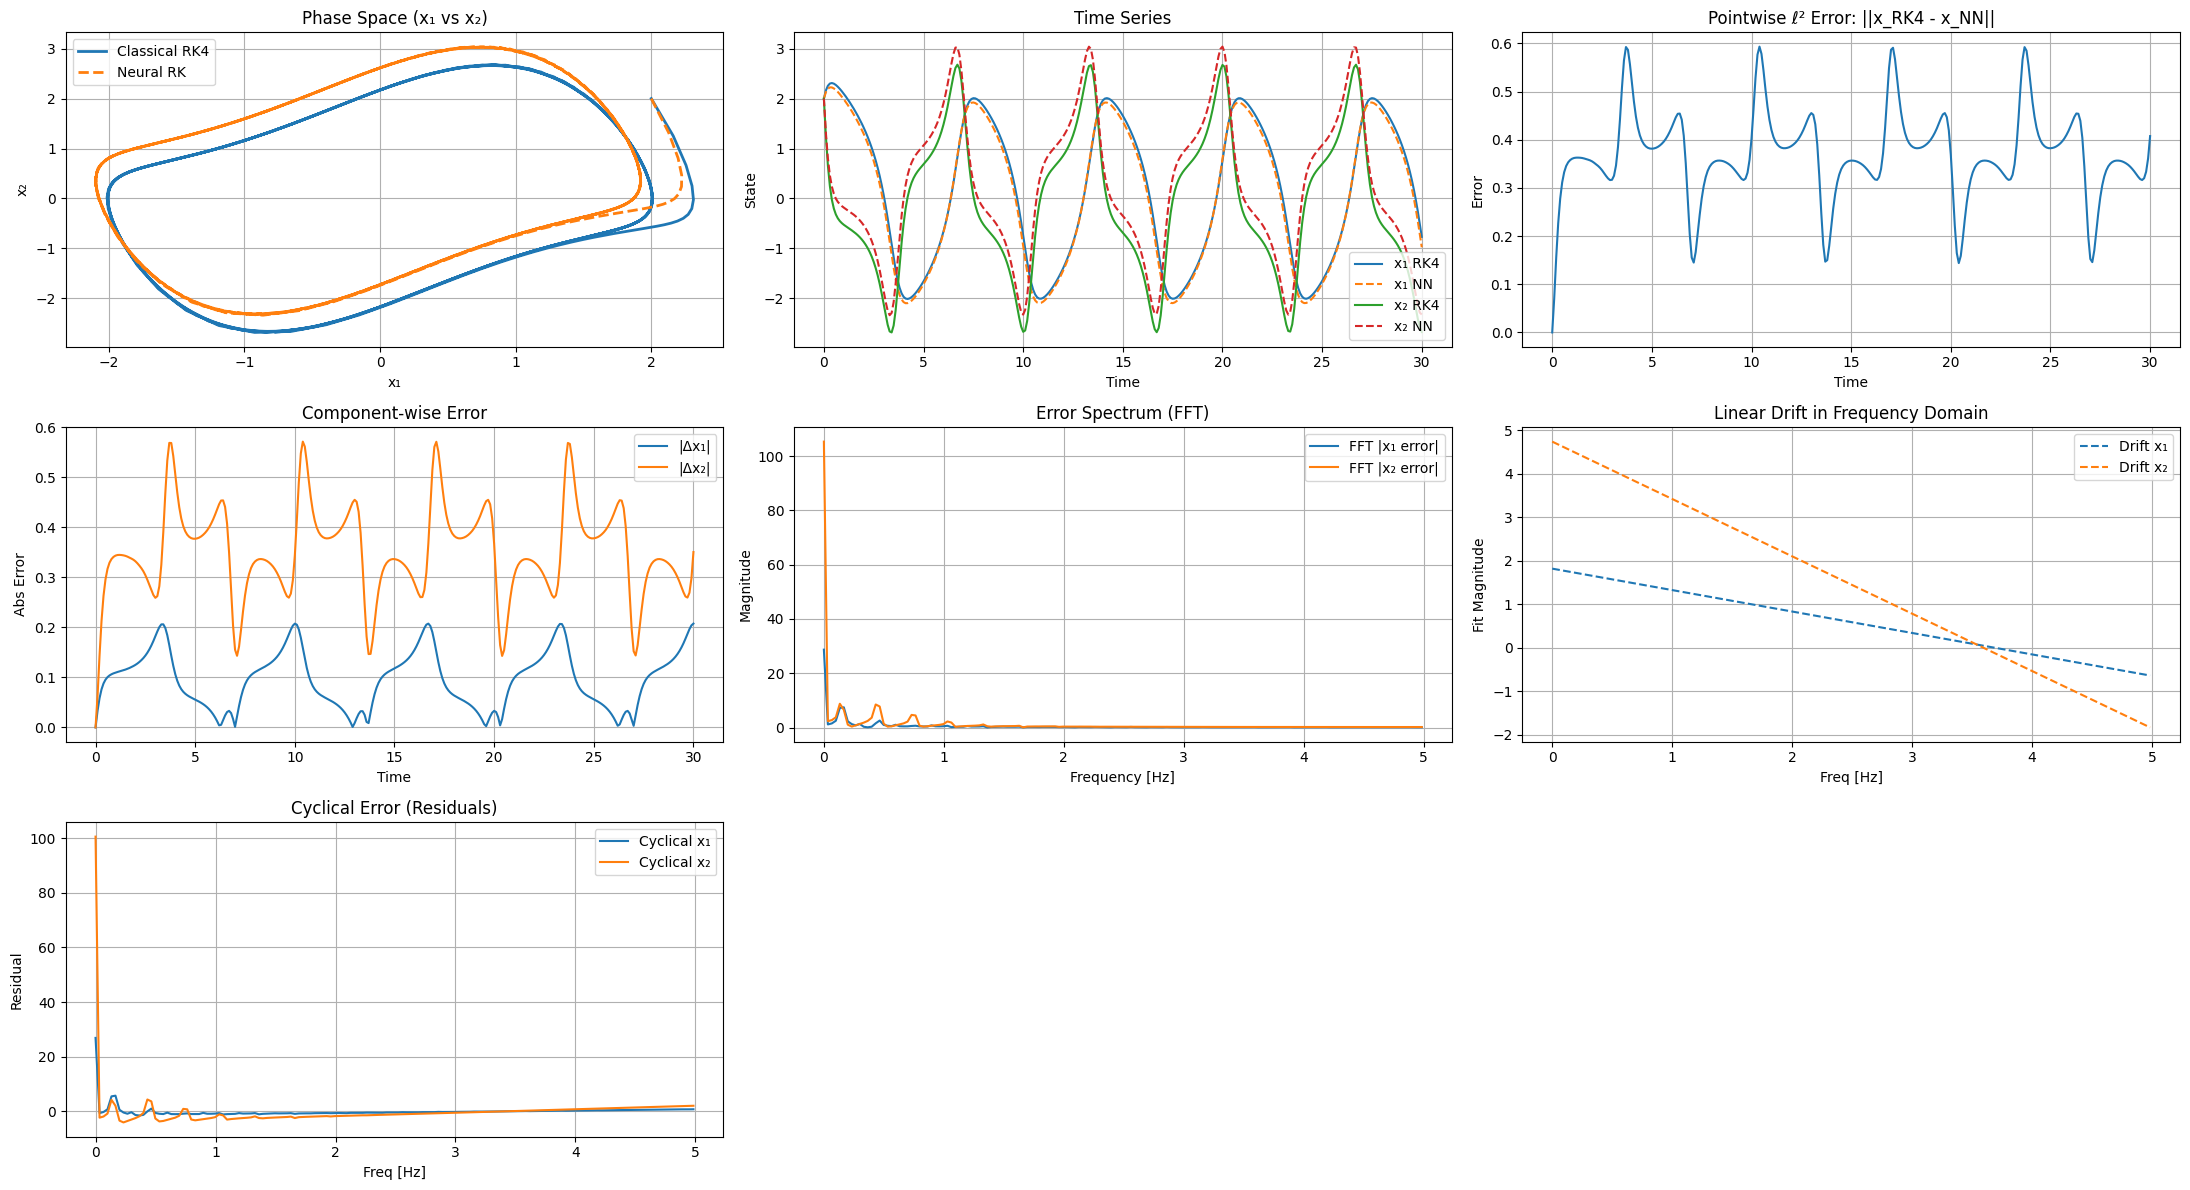

In [ ]:
full_mode_analysis(traj_rk.cpu(), traj_nn.cpu(), steps, dt)